# Player order investigation

**Background**

Some players raised concerns that the starting positions of players in the Through the Ages tournaments may not be properly random in assignment. This is due to players observing that they have a "rare" combination of seatings (for example 5 games where they are the first player). There is some suspicion that the player seating affects the overall win rate of the game

The organizer of the tournament reached out to ask if there was enough evidence to show that the player ordering is not random.

The tournament is organized into divisions (split by skill) and within each division, leagues of 5 players each, where each league has 10 games, one for each unique combination of players. Equivalently, each player can expect to play each possible combination of opponent pairs.

**Summary of report**

We first calculate the expected probability of a player having a specific seating combination, $(i, j, k)$ where i is the number of games where they are in the first seat, $j$ is the number of games where they are in the second seat, and $k$ is the number of games where they are in the third seat. In this section we ignore the interactions between players within the same league, and compare this analytical distribution to the observed distribution.

To determine if including these interaction terms impact the outcome, we then use a Monte Carlo method to simulate a series of tournaments and compare the observed data to this syntheic sample.

**Conclusions**

The distribution of seats for this tournament are consistent with what we would expect from randomly assigned seating.

**Acknowledgements**

Thanks to Pavel Ceska for organizing these great tournaments and providing the data, and Parker Trostle for reviewing the statistics presented here.

In [1]:
import collections
import functools
import math
import random
from typing import Dict, Set, Tuple
import warnings

import attr
import numpy as np
import pandas as pd
import plotnine
import scipy
import scipy.stats

# Local module used to ergonimically return data.
import fetch

warnings.filterwarnings("ignore")

In [2]:
# Use this once to choose a seed number.

# random.randint(0, 100)
# 18

random.seed(18)

## Read and transform the data.

Read in, filter, and rename the data.

In [3]:
# Load the data from the url and rename columns.
renamed_cols = {
    "division": "division",
    "position1": "1st position",
    "position2": "2nd position",
    "position3": "3rd position",
    "place1": "1st place",
    "points1": "1st points",
    "place2": "2nd place",
    "points2": "2nd points",
    "place3": "3rd place",
    "points3": "3rd points"
}

df = (
    functools.reduce(
        lambda df, item: df.assign(**{item[0]: df[item[1]]}),
        renamed_cols.items(),
        fetch.data_source(node="game_results_with_seating").as_pandas()
    )
    [renamed_cols.keys()]
)

# Remove rows without data.
filtered_df = (
    df
    .assign(game_id=tuple(range(len(df))))
    .assign(
        finish_points1=lambda df: tuple(
            (finish, points)
            for finish, points in zip(df.place1, df.points1)
        )
    )
    .assign(
        finish_points2=lambda df: tuple(
            (finish, points)
            for finish, points in zip(df.place2, df.points2)
        )
    )
    .assign(
        finish_points3=lambda df: tuple(
            (finish, points)
            for finish, points in zip(df.place3, df.points3)
        )
    )
    [df.division.notnull() & df.points3.notnull()]
)

### Transform the data from wide to long.
The data is initially in a record per game; we want the data in a record per player, specifically mapping:

`(game_id, player): (position, finish, points)`

where position is the player's seat in turn order.

In [4]:
# Create a long dataframe mapping (division, game_id, player): start_position.
start_position_df = (
    pd.melt(
        filtered_df,
        id_vars=["division", "game_id"],
        value_vars=["position1", "position2", "position3"],
        var_name="position_str",
        value_name="player"
    )
    .assign(
        position=lambda df: tuple(
            int(pos[-1])
            for pos in df.position_str
        )
    )
    .drop("position_str", axis=1)
    .reset_index(drop=True)
)

In [5]:
# Create a long dataframe mapping (game_id, player): (finish, points).
# Encode the player with an integer.

finish_df = (
    pd.melt(
        filtered_df,
        id_vars=["division", "game_id"],
        value_vars=["finish_points1", "finish_points2", "finish_points3"],
        var_name="finish_points_str",
        value_name="player_points"
    )
    .assign(player=lambda df: df.player_points.apply(lambda x: x[0]))
    .assign(points=lambda df: df.player_points.apply(lambda x: int(x[1])))
    .assign(
        finish=lambda df: tuple(
            int(pos[-1])
            for pos in df.finish_points_str
        )
    )
    .drop(["finish_points_str", "player_points"], axis=1)
    .reset_index(drop=True)
)

In [6]:
# Sort the divisions by player count - the higher skill divisions
# have less players.
# Due to the way the tournament is organized, the lowest division
# actually has less players than the second lowest (not enough players
# to fill the division), so we manually set this division to be
# the lowest.

ordered_divisions = (
    finish_df
    [["division", "player"]]
    .drop_duplicates()
    .groupby("division")
    .agg({"player": "count"})
    .reset_index()
    .assign(
        player_count=lambda df: tuple(
            count if division != "wood" else 10000000
            for count, division in zip(df.player, df.division)
        )
    )
    .sort_values("player_count", ascending=False)
    .reset_index()
    .division
    .to_list()
)

ordered_divisions

['wood', 'bronze', 'silver', 'gold', 'platinum', 'master', 'grandmaster']

In [7]:
# Join the long dataframes to create a dataframe mapping:
# (game_id, player): (start_position, finish, points)
#
# Order the divisions, as we may perform some cuts by skill level.


finish_by_start_df = (
    finish_df.merge(
        start_position_df,
        on=["division", "game_id", "player"],
        how="inner"
    )
    .assign(player=lambda df: df.player.astype("category").cat.codes)
    .assign(
        division=pd.Categorical(
            finish_df.division,
            categories=ordered_divisions
        )
    )
)

### Plot the data

As a curiosity, let's plot the distribution of the winner's points by division as well as the the points by place.

A priori I would expect that higher level players tend to create more points overall, and that the first position has a slight advantage from tempo.

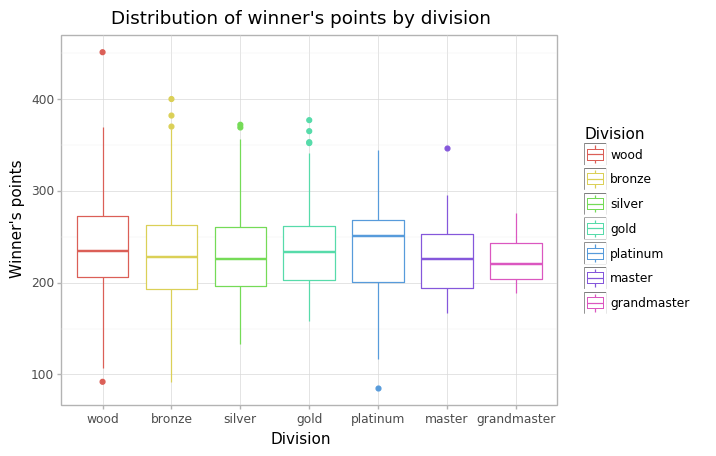

In [8]:
(
    plotnine.ggplot(
        finish_by_start_df
        .groupby(["division", "game_id"])
        .agg({"points": "max"})
        .reset_index()
    )
    + plotnine.aes(x="division", y="points", group="division", color="division")
    + plotnine.geom_boxplot()
    + plotnine.theme_light()
    + plotnine.labs(
        title="Distribution of winner's points by division",
        x="Division",
        y="Winner's points",
        color="Division"
    )
).draw();

**Figure** - Lower divisions appear to have a higher variance in the winner's points, as well as more extreme results (I personally have not participated in games where the winner scores over 400). I suspect the lower frequency of very high scores at the top divisions reflects the lower sample size as well as very greedy strategies not working as well (required for the truly high scores).

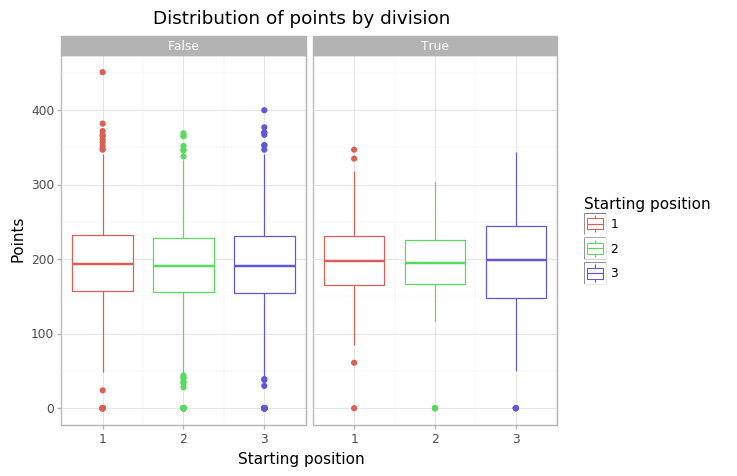

In [9]:
ordered_divisions_map = {
    division: i
    for i, division in enumerate(ordered_divisions)
}

def map_division(division: str) -> int:
    """ Map the division to an int to enable comparisions.
    """
    return int(ordered_divisions_map.get(division))

(
    plotnine.ggplot(
        finish_by_start_df
        .assign(
            encoded_division=(
                finish_by_start_df.division
                .apply(map_division)
                .astype(int)
            )
        )
        .assign(top_divisions=lambda df: df.encoded_division > 3)
    )
    + plotnine.aes(
        x="position",
        y="points",
        group="factor(position)",
        color="factor(position)"
    )
    + plotnine.geom_boxplot()
    + plotnine.facet_wrap("~top_divisions")
    + plotnine.theme_light()
    + plotnine.labs(
        title="Distribution of points by division",
        x="Starting position",
        y="Points",
        color="Starting position"
    )
).draw();

**Figure** - Nothing jumps out at first glance. The second player may have a disadvantage, and this warrants further investigation.

## Position combinations by player

Encode the position distributions by player, e.g. if a player had the following positions by game:
- game1: 1st
- game2: 3rd
- game3: 1st
- game4: 2nd
- game5: 2nd
- game6: 1st

They would have an encoding of `(3, 2, 1)`, or 3 games in first position, 2 in the second position, and 1 in the third position.

Note: We find that some players do not have 6 games and exclude them for now.

In [10]:
def encode_position(position_counts: Tuple[Tuple[int, int]]) -> Tuple[int, int, int]:
    """ Encode the position counts from
    ((position, count), ...) to
    (times in position 1, times in position 2, times in position 3)
    """
    return tuple(
        sum(
            count
            for position, count in position_counts
            if position == i + 1
        )
        for i in range(3)
    )

positions_by_player_df = (
    finish_by_start_df
    .groupby(by=["player", "position"])
    .agg(dict(game_id="size"))
    .reset_index()
    .assign(
        position_count=lambda df: tuple(
            (position, count)
            for position, count in zip(df.position, df.game_id)
        )
    )
    .groupby("player")
    .agg(dict(position_count=tuple))
    .assign(encoded_position=lambda df: df.position_count.apply(encode_position))
)

## Expected frequency of position combinations.

Calculate the expected frequency of each combination of starting positions per player and compare to the numbers observed (6 games per league).

The number of permutations to create the combination of player orders is
${6\choose {p_i}} {{6-p_i}\choose {p_j}},$ where $p_i$ is the number of times a player is in the $i$ seat, and $i\ne j$ (a multinomial distribution where k=3 and n=6). Assuming that each player's set of starting positions is independent from all other players, the probability that a player has i games in the first seat, j games in the second, and k games in the third is
$$p(i, j, k)={6\choose {p_i}} {{6-p_i}\choose {p_j}},$$
and the expected number of players with a specific combination of starts, given N players is
$$E[X_{i, j, k}] = N p(i, j, k),$$
with variance
$$Var(X_{i, j, k}) = N p(i, j, k) (1-p(i, j, k)).$$

The expected frequency of each combination ignores the constraint that within each league, each position is seen N times, where N is the number of games in the league, or $\sum\limits_{j=1}^Np_i=N,$ where $j$ is the game id. Since we have computers, we can use brute force to determine the effect of this additional constraint.

An obvious example proving that the player order combinations are not independent is a player starting first in all their games prevents any other player from starting first in all their games.

In [11]:
@functools.lru_cache()
def factorial(i: int, product: int = 1) -> int:
    """ Return i!
    """
    assert i >= 0, "Cannot take factorial of negative number."
    
    new_product = i * product
    
    return (product if i == 0 else factorial(i=i - 1, product=new_product))


def n_choose_k(n: int, k: int) -> int:
    """ Calculate n choose k.
    """
    n_factorial = factorial(n)
    
    k_factorial = factorial(k)
    
    n_k_factorial = factorial(n - k)
    
    return n_factorial // k_factorial // n_k_factorial

In [12]:
possible_positions = tuple(
    (i, j, 6 - i - j)
    for i in range(0, 7)
    for j in range(7 - i)
)

encoded_positions_frequency = collections.Counter(
    positions_by_player_df
    [positions_by_player_df.encoded_position.apply(sum) == 6]
    .encoded_position
    .to_list()
)

counts_by_comb_df = (
    pd.DataFrame(dict(encode=possible_positions))
    .assign(
        n=lambda df: tuple(
            encoded_positions_frequency.get(encode, 0)
            for encode in df.encode
        )
    )
    .assign(
        combinations=lambda df: tuple(
            n_choose_k(6, p2) * n_choose_k(6 - p2, p3)
            for p1, p2, p3 in df.encode
        )
    )
    .assign(base_prob=lambda df: df.combinations / df.combinations.sum())
    .sort_values(by="base_prob")
    .assign(
        encode=lambda df: pd.Categorical(
            df.encode,
            categories=df.encode.tolist()
        )
    )
    .assign(expected_n=lambda df: df.base_prob * df.n.sum())
    .reset_index(drop=True)
    [["encode", "combinations", "base_prob", "n", "expected_n"]]
)

### Plot expected and observed counts.

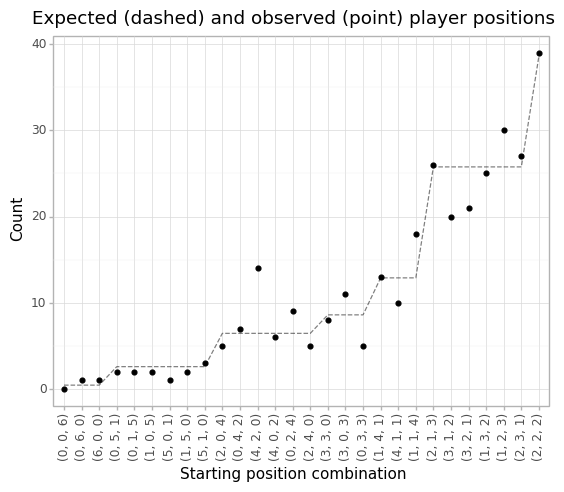

In [13]:
(
    plotnine.ggplot(counts_by_comb_df)
    + plotnine.aes(x="encode")
    + plotnine.geom_point(plotnine.aes(y="n"))
    + plotnine.geom_line(
        plotnine.aes(y="expected_n", group=1),
        linetype="dashed",
        alpha=0.5
    )
    + plotnine.theme_light()
    + plotnine.theme(axis_text_x=plotnine.element_text(angle=90, vjust=1, hjust=0.5))
    + plotnine.labs(
        title="Expected (dashed) and observed (point) player positions",
        x="Starting position combination",
        y="Count"
    )
).draw();

**Figure** - Observed (points) compared to expected (dashed) counts of starting position combinations by player, where the starting position is defined as a tuple of (starts in position 1, starts in position 2, starts in position 3).

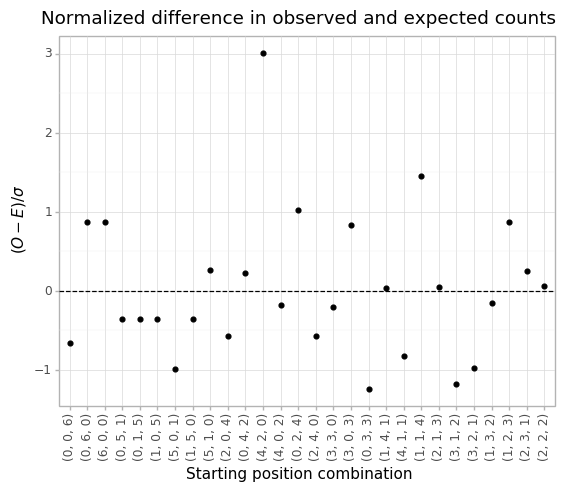

In [14]:
(
    plotnine.ggplot(
        counts_by_comb_df
        .assign(var=lambda df: df.n.sum() * df.base_prob * (1. - df.base_prob))
        .assign(res_norm=lambda df: (df.n - df.expected_n) / df["var"].apply(np.sqrt))
    )
    + plotnine.aes(x="encode", y="res_norm")
    + plotnine.geom_point()
    + plotnine.geom_hline(yintercept=0., linetype="dashed")
    + plotnine.theme_light()
    + plotnine.theme(axis_text_x=plotnine.element_text(angle=90, vjust=1, hjust=0.5))
    + plotnine.labs(
        title="Normalized difference in observed and expected counts",
        y="$(O - E) / \sigma$",
        x="Starting position combination"
    )
).draw();

**Figure** - Residual between the observed and expected number of starting position combinations per player, normalized by the expected standard deviation $\sigma(n, p) = np(1-p)$. There does not appear to be an obvious correlation. 

In [15]:
## Perform a chi-square on expected vs. observed.

scipy.stats.chisquare(
    f_obs=counts_by_comb_df.n.to_list(),
    f_exp=counts_by_comb_df.expected_n.to_list()
)

Power_divergenceResult(statistic=21.959584664536745, pvalue=0.7394281331906609)

**Conclusion** - So far, we have not found evidence that the player seatings are different than what we expect from a random assignment.

## Monte carlo method with simulated tournaments.

In a league with 5 players and 6 games, each combination of 3 players is assigned to play in a game ${4\choose2},$ resulting in 6 games with a unique combination of players. The preceding section estimated the expected frequency of starting position combinations by player, ignoring the constraints set by the league structure, there are N players in each starting position, where N is the number of games), and each game has a unique combination of players (the combination of games in the league will contain each possible combination of players).

We use a monte carlo method to generate a series of tournaments and determine if our observed distribution of player seating combinations is consistent with our synthetic distribution.

In [16]:
# Number of leagues per tournament and how many tournaments to simulate.

n_leagues = 95
n_tournaments = 10000

In [17]:
# Combination of players, where each player is represented by an
# id from 0-4. A combination of (0, 3, 4) means a game with the
# participants 0, 3, and 4.

StartingPositions = collections.namedtuple(
    "StartingPositions",
    ("p1", "p2", "p3")
)

combinations = tuple(
    StartingPositions(i, j, k)
    for i in range(3)
    for j in range(i + 1, 4)
    for k in range(j + 1, 5)
)

@attr.s(auto_attribs=True)
class League(object):
    """ Simulate a league of 6 games played by 5 players, where each
    game contains a unique combination of players. The ten games in a
    league will contain each potential combination of players.
    """
    @property
    def matches(self) -> Tuple[StartingPositions, ...]:
        """ Assign matches by randomly drawing each player from each combination,
        where the tuple are the player ids in turn order.
        """
        return tuple(
            StartingPositions(*random.sample(match, 3))
            for match in combinations
        )
    
    @property
    def places_by_player(self) -> Dict[StartingPositions, collections.Counter]:
        """ Return a mapping of starting position frequency by player.
        """
        matches = self.matches
        
        matches_by_place = tuple(
            {p: i for i, p in enumerate(match)}
            for match in matches
        )
        
        return {
            p: collections.Counter(
                match.get(p)
                for match in matches_by_place
                if match.get(p) is not None
            )
            for p in range(5)
        }
    
    @property
    def encoded_places(self) -> Tuple[StartingPositions, ...]:
        """ Return a mapping of starting position frequency by player.
        """
        places = self.places_by_player
        
        return tuple(
            tuple(p.get(i, 0) for i in range(3))
            for player, p in places.items()
        )
    

@attr.s(auto_attribs=True, hash=False)
class Tournament(object):
    """ Create distributions of player positions for a tournament.
    """
    n_leagues: int = 95
        
    @property
    def leagues(self) -> Tuple[League, ...]:
        """ Create league objects.
        """
        n_leagues = self.n_leagues
        
        return tuple(League() for i in range(n_leagues))
    
    @property
    @functools.lru_cache(maxsize=100000)
    def places_count(self) -> collections.Counter:
        """ Starting positions by player within the simulated tournament.
        """
        leagues = self.leagues
        
        return collections.Counter(
            places
            for league in leagues
            for places in league.encoded_places
        )
    
    def count_outliers(
        self,
        confidence_intervals: Dict[StartingPositions, Tuple[float, float]]
    ) -> int:
        """ Returns the number of observations falling outside of the
        input confidence interval.
        """
        places_count = self.places_count
        
        return sum(
            (
                (places_count.get(position, 0.) > lower_ci)
                | (places_count.get(position, 0.) < upper_ci)
            )
            for position, (upper_ci, lower_ci) in confidence_intervals.items()
        )

In [18]:
# Create a dictionary mapping the distribution of counts by position.

tournaments = tuple(
    Tournament(n_leagues=n_leagues)
    for i in range(n_tournaments)
)

position_counts_tournaments = {
    position: sorted(
        tournament.places_count.get(position, 0)
        for tournament in tournaments
    )
    for position in possible_positions
}

In [19]:
# We calculate the 95% confidence intervals from the outcomes of the
# simulated tournaments, as well as a conservative confidence interval
# using the Bonferroni correction (we have 28 hypotheses).
#
# Because the actual number of leagues we observe is different (and due
# to filtering data, we have incomplete leagues), we normalize the distribution
# of the synthetic distribution by the number of observed leagues / simulated
# leagues.

f = (counts_by_comb_df.n.sum() / 5) / n_leagues
alpha = 0.05 / 2.
alpha_conservative = alpha / len(possible_positions)

confidence_intervals_by_position_df = pd.DataFrame(
    {
        "encode": position,
        "lower_ci": math.floor(f * counts[int(n_tournaments * alpha)]),
        "lower_ci_bc": math.floor(f * counts[int(n_tournaments * alpha_conservative)]),
        "median": f * counts[n_tournaments // 2],
        "upper_ci": math.ceil(f * counts[int(n_tournaments * (1. - alpha))]),
        "upper_ci_bc": math.ceil(f * counts[int(n_tournaments * (1. - alpha_conservative))]),
        "expected_value": f * sum(counts) / len(counts)
    }
    for position, counts in position_counts_tournaments.items()
)

# Merge the confidence intervals from the synthetic distribution to
# the observed and approximated expected values.

synthetic_and_observed_df = (
    counts_by_comb_df.merge(
        confidence_intervals_by_position_df,
        on=["encode"],
        how="inner"
    )
    .assign(
        encode=lambda df: pd.Categorical(
            df.encode,
            categories=df.encode.tolist()
        )
    )
)

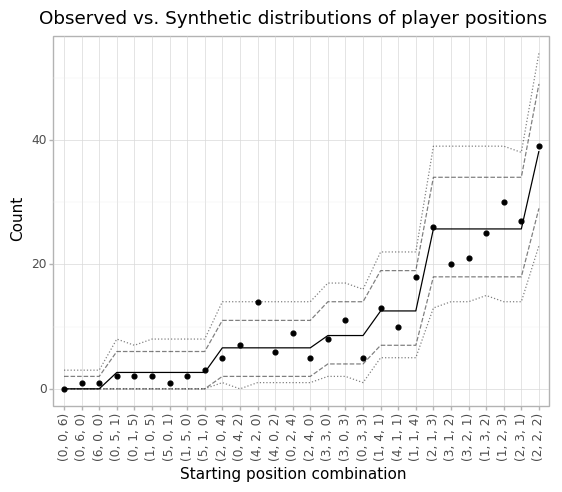

In [20]:
(
    plotnine.ggplot(synthetic_and_observed_df)
    + plotnine.aes(x="encode")
    + plotnine.geom_point(plotnine.aes(y="n"))
    + plotnine.geom_line(plotnine.aes(y="median", group=1))
    + plotnine.geom_line(
        plotnine.aes(y="lower_ci", group=1),
        linetype="dashed",
        alpha=0.5
    )
    + plotnine.geom_line(
        plotnine.aes(y="upper_ci", group=1),
        linetype="dashed",
        alpha=0.5
    )
    + plotnine.geom_line(
        plotnine.aes(y="lower_ci_bc", group=1),
        linetype="dotted",
        alpha=0.5
    )
    + plotnine.geom_line(
        plotnine.aes(y="upper_ci_bc", group=1),
        linetype="dotted",
        alpha=0.5
    )
    + plotnine.theme_light()
    + plotnine.theme(
        axis_text_x=plotnine.element_text(angle=90, vjust=1, hjust=0.5)
    )
    + plotnine.labs(
        title="Observed vs. Synthetic distributions of player positions",
        x="Starting position combination",
        y="Count"
    )
).draw();

**Figure** - Observed (points) points and confidence intervals for $\alpha=0.05$ (dashed) and with a Bonferroni correction (dotted). The starting position is defined as a tuple of (starts in position 1, starts in position 2, starts in position 3). We note that the $(0, 4, 2)$ combination falls outside the uncorrected confidence interval but is close to the corrected confidence interval boundary.

This plot shows that the observed seating combination distribution is mostly consistent with randomly assigned seating, with a relatively rare number of players with a $(0, 4, 2)$ seating combination.

### Expected number of observations outside of CI.

For completeness, we use the synthetic distribution to estimate the frequency of the number of individual observations per tournament to fall outside of both the uncorrected and corrected confidence intervals.

In [21]:
confidence_intervals = {
    encode: (lower_ci / f, upper_ci / f)
    for encode, lower_ci, upper_ci in zip(
        synthetic_and_observed_df.encode,
        synthetic_and_observed_df.lower_ci,
        synthetic_and_observed_df.upper_ci
    )
}

confidence_intervals_bc = {
    encode: (lower_ci / f, upper_ci / f)
    for encode, lower_ci, upper_ci in zip(
        synthetic_and_observed_df.encode,
        synthetic_and_observed_df.lower_ci_bc,
        synthetic_and_observed_df.upper_ci_bc
    )
}

outliers_df = pd.DataFrame(
    {
        "outliers": tuple(
            tournament.count_outliers(confidence_intervals)
            for tournament in tournaments
        ),
        "outliers_bc": tuple(
            tournament.count_outliers(confidence_intervals_bc)
            for tournament in tournaments
        )
    }
)

In [22]:
outliers_merged_df = (
    (
        outliers_df
        .groupby("outliers")
        .agg(dict(outliers="count"))
        .assign(percent=lambda df: df.outliers / df.outliers.sum())
        [["percent"]]
        .reset_index()
    )
    .merge(
        outliers_df
        .groupby("outliers_bc")
        .agg(dict(outliers="count"))
        .assign(percent_bc=lambda df: df.outliers / df.outliers.sum())
        .reset_index()
        .assign(outliers=lambda df: df.outliers_bc)
        [["outliers", "percent_bc"]],
        on="outliers",
        how="left"
    )
    .fillna(0.)
)

In [23]:
outliers_merged_df.round(3)

,outliers,percent,percent_bc
0,0,0.529,0.982
1,1,0.327,0.018
2,2,0.111,0.000
3,3,0.027,0.000
4,4,0.005,0.000
5,5,0.000,0.000
6,6,0.000,0.000


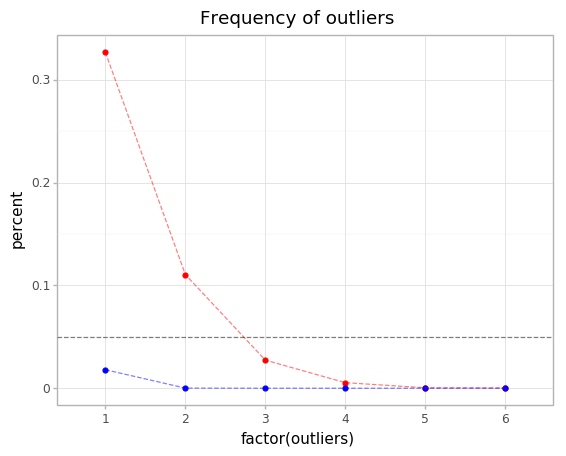

In [24]:
(
    plotnine.ggplot(outliers_merged_df[outliers_merged_df.outliers > 0])
    + plotnine.aes(x="factor(outliers)")
    + plotnine.geom_point(plotnine.aes(y="percent"), color="red")
    + plotnine.geom_point(plotnine.aes(y="percent_bc"), color="blue")
    + plotnine.geom_line(
        plotnine.aes(x="outliers", y="percent"),
        color="red",
        linetype="dashed",
        alpha=0.5
    )
    + plotnine.geom_line(
        plotnine.aes(x="outliers", y="percent_bc"),
        color="blue",
        linetype="dashed",
        alpha=0.5
    )
    + plotnine.geom_hline(yintercept=0.05, linetype="dashed", alpha=0.5)
    + plotnine.theme_light()
    + plotnine.labs(
        title="Frequency of outliers",
        
    )
).draw();

**Figure** - We see that, assuming an $\alpha=0.05,$ having up to 3 outliers is not uncommon.

### Differences between analytical approximation.

Finally, we create a plot showing the difference in the expected values calculated by the monte carlo method and analytical approximation to examine potential impacts of ignored constraints within a league.

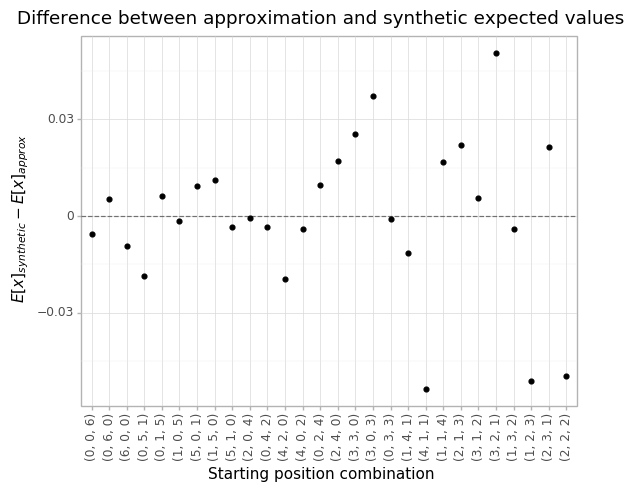

In [25]:
(
    plotnine.ggplot(
        synthetic_and_observed_df
        .assign(delta=lambda df: df.expected_value - df.expected_n)
    )
    + plotnine.aes(x="encode", y="delta")
    + plotnine.geom_point()
    + plotnine.geom_hline(yintercept=0., linetype="dashed", alpha=0.5)
    + plotnine.theme_light()
    + plotnine.theme(axis_text_x=plotnine.element_text(angle=90, vjust=1, hjust=0.5))
    + plotnine.labs(
        title="Difference between approximation and synthetic expected values",
        x="Starting position combination",
        y="$E[x]_{synthetic}-E[x]_{approx}$"
    )
).draw();

**Figure** - Difference by encode between the expected values calculated by the monte carlo method and the analytical approximation (ignoring interactions within leagues). We do not see an obvious autocorrelation.